In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import gmean, rankdata
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import KFold, cross_val_score

In [2]:
import missingno as msno

In [7]:
#!pip install catboost

In [8]:
#!pip install missingno

In [5]:
import catboost as cb

In [6]:
import warnings
warnings.simplefilter("ignore")

In [12]:
df_pay = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/payments.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/test.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/Kaggle_course/Competition/train.csv')

print("df_pay.shape = {} rows, {} cols".format(*df_pay.shape))
print("df_test.shape = {} rows, {} cols".format(*df_test.shape))
print("df_train.shape = {} rows, {} cols".format(*df_train.shape))

df_pay.shape = 1023932 rows, 8 cols
df_test.shape = 165141 rows, 2 cols
df_train.shape = 110093 rows, 3 cols


In [13]:
# объединяем трейн и тест
data = pd.concat([df_train, df_test], axis=0)
data = data.reset_index(drop=True)
data.head(n=2)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0.0,Cash
1,123597908,1.0,Cash


In [14]:
def clean_input(data) -> pd.DataFrame:
    """
    Перевод названий колонок в нижний регистр и вывод основной информации о наборе данных

    Parameters
    ----------
    data: Pandas DataFrame

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    #base_path = "data"
    #data = pd.read_csv(f"{base_path}/{data_path}")
    # Приводим все названия колонок к нижнему регистру
    data.columns = [col.lower() for col in data.columns]
    #print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    print(f"shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [15]:
df_pay = clean_input(df_pay)
data = clean_input(data)

shape = 1023932 rows, 8 cols
shape = 275234 rows, 3 cols


In [16]:
data = data.merge(
    df_pay, how="left", on="application_number"
)

In [17]:
data.describe()

,application_number,target,prev_application_number,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
count,8.610630e+05,345065.000000,7.903690e+05,790369.000000,790369.000000,790369.000000,790216.000000,7.903690e+05,7.902160e+05
mean,1.235775e+08,0.080205,4.917252e+07,0.856671,18.869571,1041.432946,1050.304338,1.715205e+04,1.735611e+04
std,8.867262e+04,0.271611,5.360582e+05,1.056206,26.673308,801.059474,800.715245,5.124538e+04,5.565510e+04
min,1.234233e+08,0.000000,4.826822e+07,0.000000,1.000000,2.000000,2.000000,0.000000e+00,0.000000e+00
25%,1.235011e+08,0.000000,4.870321e+07,0.000000,4.000000,360.000000,370.000000,4.221765e+03,3.388320e+03
50%,1.235775e+08,0.000000,4.916666e+07,1.000000,8.000000,816.000000,825.000000,8.873415e+03,8.119283e+03
75%,1.236544e+08,0.000000,4.963779e+07,1.000000,19.000000,1653.000000,1662.000000,1.672285e+04,1.612800e+04
max,1.237309e+08,1.000000,5.011171e+07,178.000000,265.000000,2922.000000,3054.000000,2.478657e+06,2.478657e+06


In [18]:
data.shape

(861063, 10)

In [19]:
#Анализ пропусков

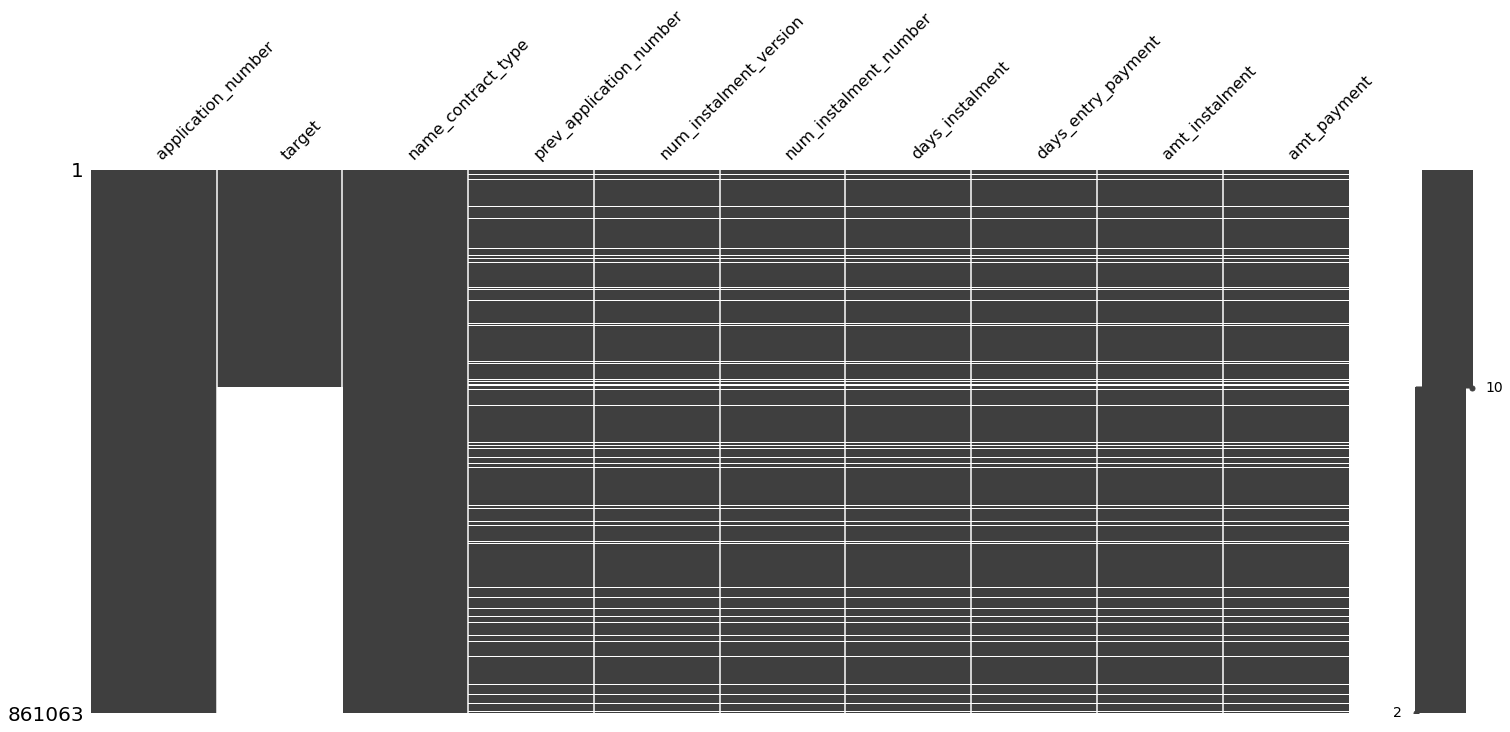

In [20]:
msno.matrix(data)

In [21]:
target = df_train['TARGET']

In [22]:
# выделяем по маске данные из трейна и из теста
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

# разделяем на трейн и тест
train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

In [23]:
train.shape

(345065, 8)

In [24]:
test.shape

(515998, 8)

In [26]:
numerical_features = data.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 9


Index(['application_number', 'target', 'prev_application_number',
       'num_instalment_version', 'num_instalment_number', 'days_instalment',
       'days_entry_payment', 'amt_instalment', 'amt_payment'],
      dtype='object')

In [28]:
def group_graf(group):
    fig, axes = plt.subplots(2, 4, figsize=(17, 12))

    for num, feature in enumerate(group):
        try:
            train_data, test_data = train[feature].copy(), test[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
            sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
        except RuntimeError:
            pass
        except KeyError:
            train_data = train[feature].copy()
            sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        axes[num//4, num%4].set_title(feature, fontsize=14)

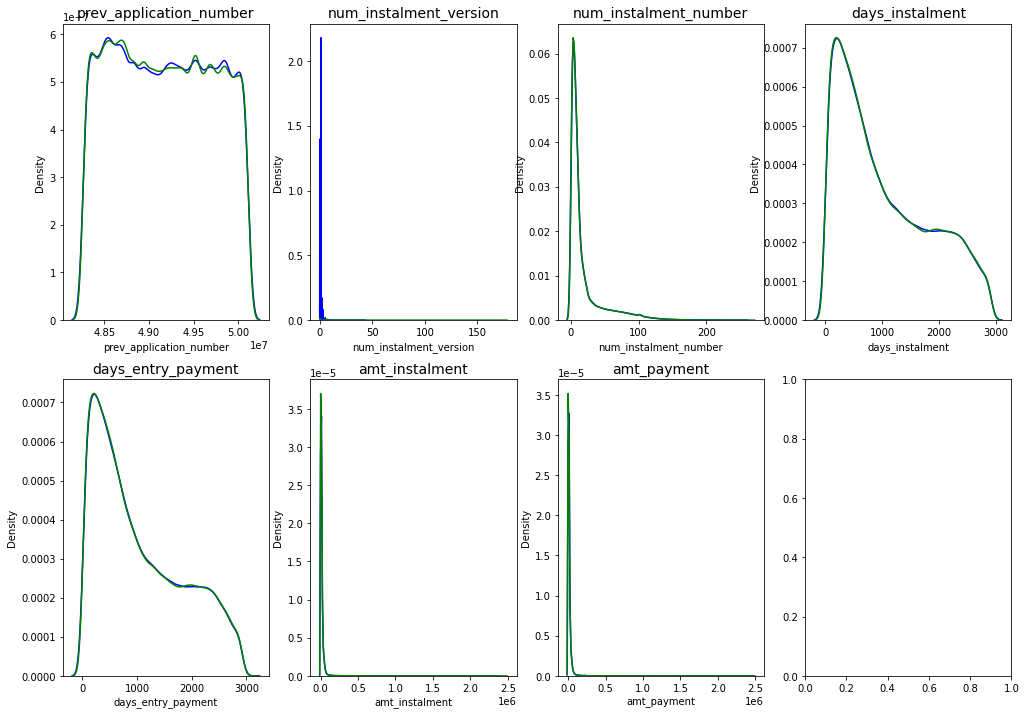

In [29]:
group = numerical_features.drop(features_to_drop, axis=1)
group_graf(group)

In [30]:
#amt_instalment, amt_payment, num_instalment_number - попробовать логарифмирование. 

In [ ]:
#немного напрягает total salary и amt_credit_bureau_year
#виден выброс по 'days on last job"

In [38]:
def feat_target_graf(group): 
    fig, axes = plt.subplots(2, 4, figsize=(17, 12))

    for num, feature in enumerate(group):
        target_0 = numerical_features.loc[numerical_features['target'] == 0, feature]
        target_1 = numerical_features.loc[numerical_features['target'] == 1, feature] 
                    
        sns.kdeplot(target_0, ax=axes[num//4, num%4], color="blue", label="0")
        sns.kdeplot(target_1, ax=axes[num//4, num%4], color="red", label="1")
            
        axes[num//4, num%4].set_title(feature, fontsize=14)

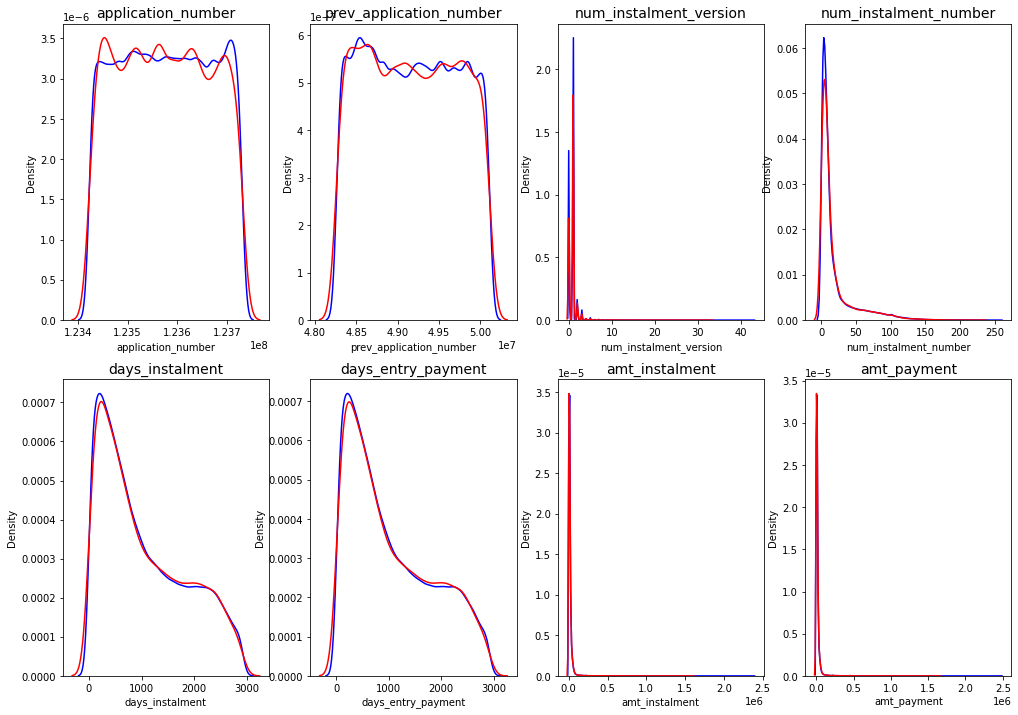

In [40]:
group = numerical_features.drop('target', axis=1)
feat_target_graf(group)

In [41]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)

CPU times: user 80 µs, sys: 0 ns, total: 80 µs
Wall time: 229 µs


In [43]:
numeric_features = numerical_features.drop(['target', 'application_number'], axis=1).columns.to_list()

In [44]:
numeric_features

['prev_application_number',
 'num_instalment_version',
 'num_instalment_number',
 'days_instalment',
 'days_entry_payment',
 'amt_instalment',
 'amt_payment']

In [45]:
#сразу оценим нелинейную связь

In [47]:
forest.fit(train[numeric_features].fillna(-9999), target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=2, oob_score=False,
                      random_state=27, verbose=0, warm_start=False)

Text(0.5, 1.0, 'What are the top important features to start with?')

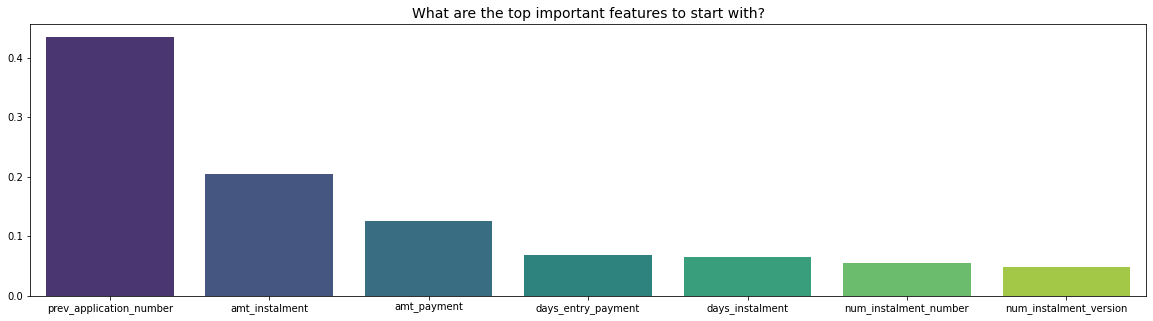

In [48]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train[numeric_features].columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [49]:
X_adv = pd.concat([
    train[numeric_features], test[numeric_features]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [50]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)
print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5115
CPU times: user 2min 31s, sys: 141 ms, total: 2min 31s
Wall time: 1min 17s


Text(0.5, 1.0, 'Top Importance Features for Adversarial Validation (train vs test)')

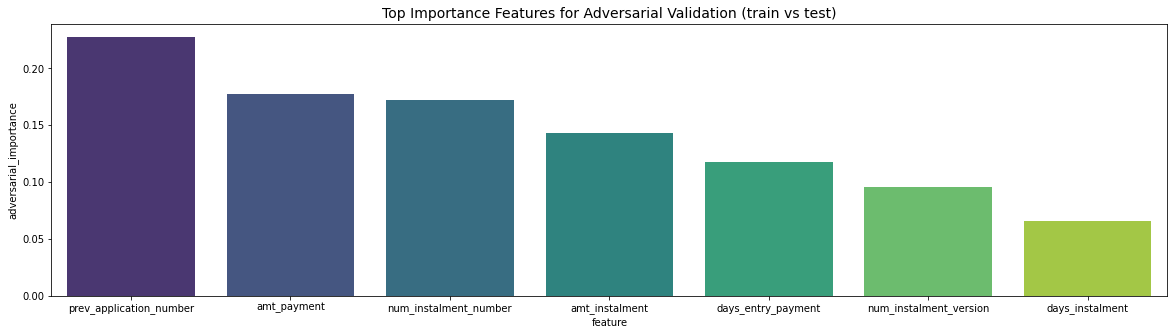

In [51]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=10)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

In [52]:
#уделить внимание вот этим двум признакам - amt_payment, num_instalment_number